In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from src.network.evaluation import evaluate
from src.network.training import train
from src.preprocessing.dataset import ChessSquareDataset, ChessBoardDataset
from src.utils.dataset_utils import get_dataset_stats, build_transforms
from src.utils.plotting import visualize_test_samples, plot_training_history
from tqdm import tqdm
import numpy as np

In [2]:
# Setup 

TRAIN_DATA_ROOT = "data/train/synthetic"
VAL_DATA_ROOT = "data/validation/synthetic"
BATCH_SIZE = 2
NUM_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

temp_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Load Raw Dataset
train_dataset = ChessBoardDataset(root_dir=TRAIN_DATA_ROOT, transform=temp_transform)
val_dataset = ChessBoardDataset(root_dir=VAL_DATA_ROOT, transform=temp_transform)

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

# Compute Statistics (Train Set Only)
train_mean, train_std = get_dataset_stats(train_dataset, batch_size=256, num_workers=NUM_WORKERS)
print(f"\nCalculated Training Mean: {train_mean}")
print(f"Calculated Training Std:  {train_std}")

# Build Final datasets and DataLoaders
baseline_config = {} 
final_transform = build_transforms(train_mean, train_std, config=baseline_config)

train_dataset = ChessBoardDataset(root_dir=TRAIN_DATA_ROOT, transform=final_transform)
val_dataset = ChessBoardDataset(root_dir=VAL_DATA_ROOT, transform=final_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device: cuda
Training samples: 1125 | Validation samples: 243
Computing mean and std for training data...


Calculating Stats: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Calculated Training Mean: [0.5405116677284241, 0.5397956371307373, 0.5381444692611694]
Calculated Training Std:  [0.10387232899665833, 0.10447882860898972, 0.10541636496782303]


In [3]:
# Define baseline model

def get_baseline_model(num_classes=13):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Replace final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [4]:
# Initialize

model = get_baseline_model().to(device)

print("\nModel Initialized: ResNet18 (Pretrained)")
print(f"Output classes: {model.fc.out_features}")


Model Initialized: ResNet18 (Pretrained)
Output classes: 13


Training on cuda for 15 epochs...


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train: Loss=0.0795 Acc=0.9907  Val: Loss=0.0095 Acc=0.9979   [Saved Best]
Epoch 2/15 | Train: Loss=0.0010 Acc=1.0000  Val: Loss=0.0046 Acc=0.9988   [Saved Best]
Epoch 3/15 | Train: Loss=0.0186 Acc=0.9986  Val: Loss=0.0328 Acc=0.9965  
Epoch 4/15 | Train: Loss=0.0055 Acc=0.9995  Val: Loss=0.0016 Acc=1.0000   [Saved Best]
Epoch 5/15 | Train: Loss=0.0002 Acc=1.0000  Val: Loss=0.0015 Acc=1.0000  
Epoch 6/15 | Train: Loss=0.0001 Acc=1.0000  Val: Loss=0.0010 Acc=1.0000  
Epoch 7/15 | Train: Loss=0.0001 Acc=1.0000  Val: Loss=0.0006 Acc=1.0000  
Epoch 8/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0004 Acc=1.0000  
Epoch 9/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0004 Acc=1.0000  
Epoch 10/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0004 Acc=1.0000  
Epoch 11/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0002 Acc=1.0000  
Epoch 12/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0003 Acc=1.0000  
Epoch 13/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0002 Acc=1.00

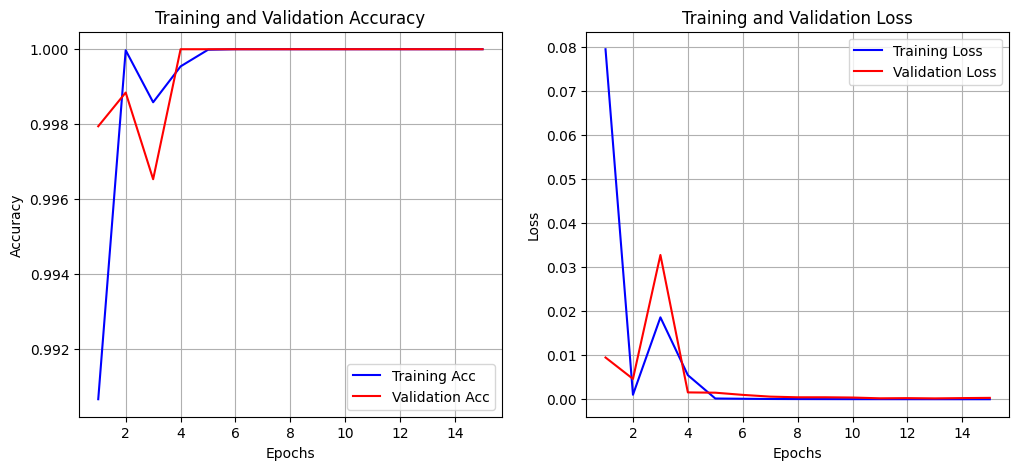

In [5]:
# Training loop

# Configuration
lr = 1e-4
num_epochs = 15
class_weights = torch.ones(13) 
class_weights[12] = 0.1 
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
best_model, history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    num_epochs=num_epochs,
    device=device,
    save_path='baseline_resnet18.pth'
)

# Plotting train and validation statistics
plot_training_history(history)

In [6]:
# Evaluation on synthetic test data

synth_test_dataset = ChessBoardDataset(
    root_dir="data/test/synthetic", 
    transform=final_transform,
    padding=0.0
)

test_loader = DataLoader(synth_test_dataset, batch_size=32, shuffle=False)

square_acc, board_acc = evaluate(best_model, test_loader, device)

print(f"Square accuracy: {square_acc:.2f}")
print(f"Board accuracy: {board_acc:.2f}")

Starting Evaluation on 384 boards...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Square accuracy: 99.99
Board accuracy: 99.48


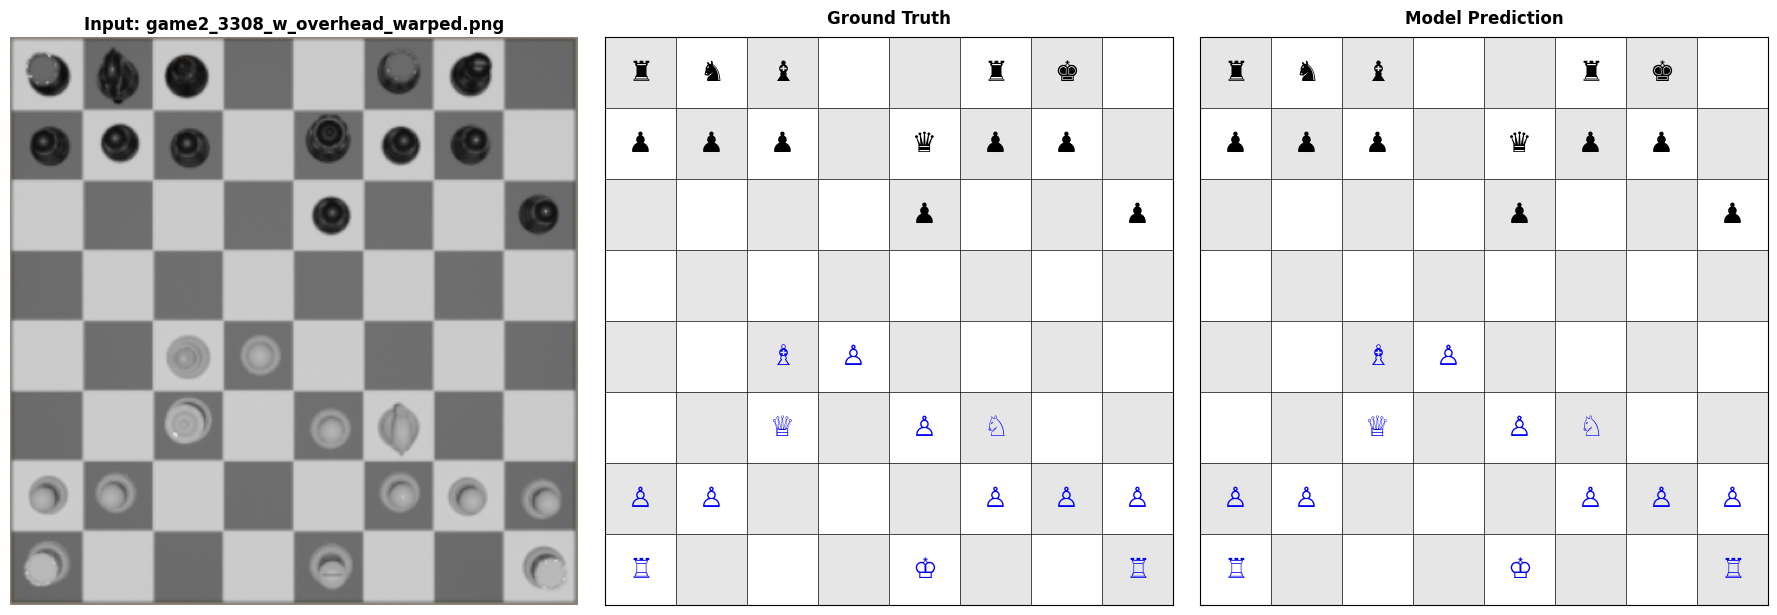

True FEN: rnb2rk1/ppp1qpp1/4p2p/8/2BP4/2Q1PN2/PP3PPP/R3K2R
Pred FEN: rnb2rk1/ppp1qpp1/4p2p/8/2BP4/2Q1PN2/PP3PPP/R3K2R
PERFECT MATCH


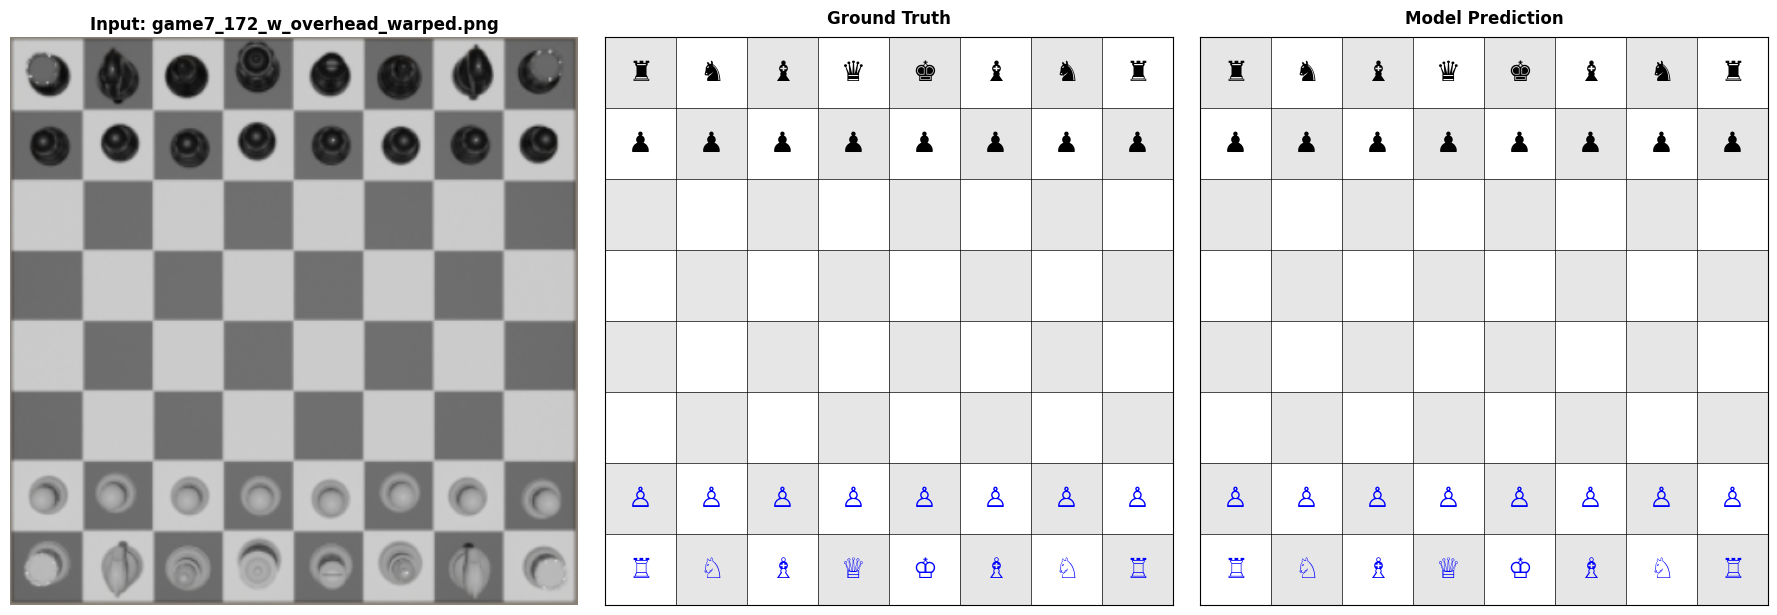

True FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
Pred FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
PERFECT MATCH


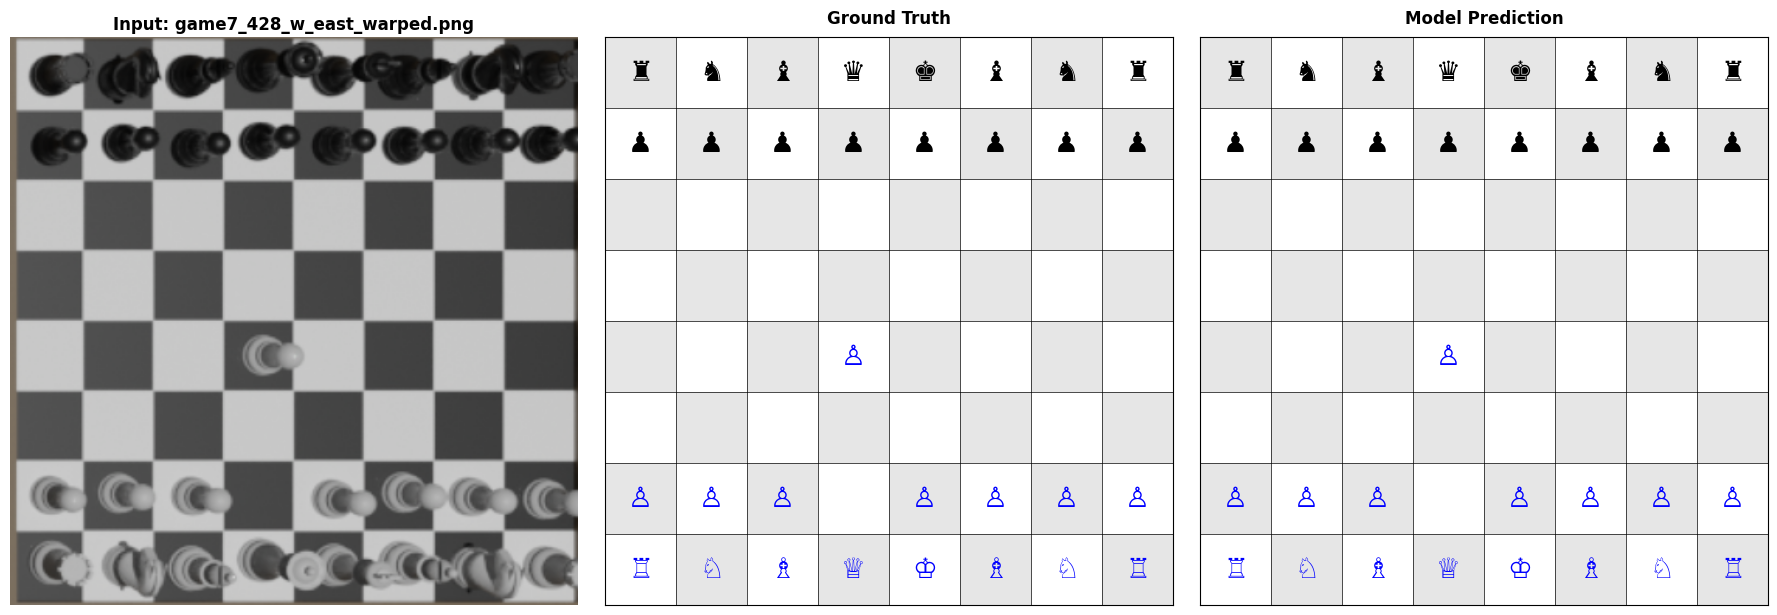

True FEN: rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR
Pred FEN: rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR
PERFECT MATCH


In [8]:
synth_test_dataset.return_fen = True
visualize_test_samples(model, synth_test_dataset, num_samples=3, device=device)